In [1]:
# https://github.com/bentrevett/pytorch-sentiment-analysis
!pip install spacy

In [2]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/senhmo/anaconda3/lib/python3.6/site-packages/en_core_web_sm -->
/Users/senhmo/anaconda3/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
import spacy

spacy.__version__

'2.2.4'

In [4]:
import torch
import torchtext
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# http://thicknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/
tweets = pd.read_csv('datasets/tweets/tweets.csv', error_bad_lines = False)
tweets = tweets.head(5000)
tweets.head()

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [6]:
tweets = tweets.drop(columns = ['ItemID', 'SentimentSource'], axis =1)
tweets.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [7]:
tweets.shape

(5000, 2)

In [8]:
tweets['Sentiment'].unique()

array([0, 1])

In [9]:
tweets.Sentiment.value_counts()

0    3555
1    1445
Name: Sentiment, dtype: int64

[Text(0.5, 0, 'Labels')]

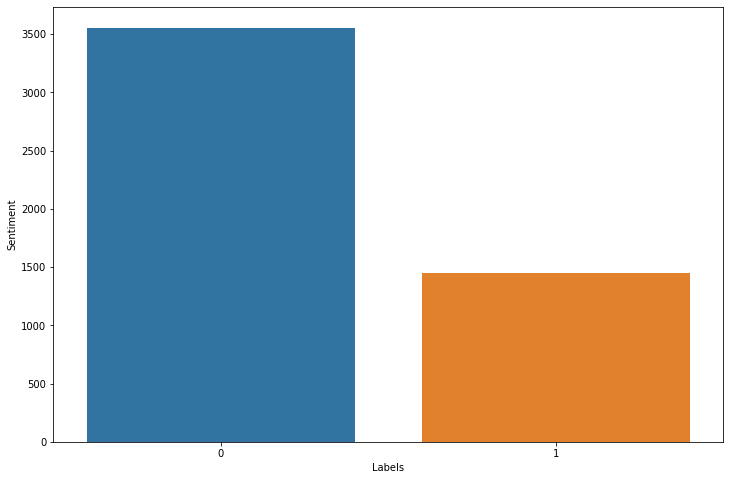

In [10]:
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(x=tweets.Sentiment.unique(), y=tweets.Sentiment.value_counts())
ax.set(xlabel='Labels')

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(tweets, test_size=0.2, random_state=42)

In [12]:
train.reset_index(drop=True), test.reset_index(drop=True)

(      Sentiment                                      SentimentText
 0             0      My sunglasses are full of Ben&amp;JerryÂ´s !!
 1             1                Sleepy time after Men vs Wild.&lt;3
 2             0                             but I love you, Aaron.
 3             0                            i've lost my clearways.
 4             1   yeps! )) that was amazing! xD finally somethi...
 ...         ...                                                ...
 3995          1   partying with the home dogs. Lmao and mark he...
 3996          1                 ahh school on monday!!!! not ready
 3997          0            I want LinesVines and trying times now 
 3998          0   Joseph Adam Jonas! You keep a smile on my fac...
 3999          0   Dinara lost again in Roland Garros. Why the S...
 
 [4000 rows x 2 columns],
      Sentiment                                      SentimentText
 0            0                       but theres always tomorrow..
 1            1   I ge

In [13]:
train.to_csv('datasets/tweets/train_tweets.csv', index=False)
test.to_csv('datasets/tweets/test_tweets.csv', index=False)


In [14]:
!ls datasets/tweets

test_tweets.csv  train_tweets.csv tweets.csv


In [15]:
def tweet_clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r'https?:/\/\S+', ' ', text)
    return text.strip()

In [16]:
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

def tokenizer(s):
    return [w.text.lower() for w in nlp(tweet_clean(s))]

In [17]:
TEXT = torchtext.data.Field(tokenize=tokenizer)
LABEL = torchtext.data.Field(dtype=torch.float)

In [18]:
datafields = [('Sentiment', LABEL), ('SentimentText', TEXT)]

In [19]:
trn, tst = torchtext.data.TabularDataset.splits(path = 'datasets/tweets/',
                                               train = 'train_tweets.csv',
                                               test = 'test_tweets.csv',
                                               format = 'csv',
                                               skip_header = True,
                                               fields = datafields)

In [20]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of testing examples: {len(tst)}')

Number of training examples: 4000
Number of testing examples: 1000


In [21]:
vars(trn.examples[0])

{'Sentiment': ['0'],
 'SentimentText': ['my',
  'sunglasses',
  'are',
  'full',
  'of',
  'ben',
  'amp',
  'jerry',
  's']}

In [22]:
TEXT.build_vocab(trn, max_size=25000,
                vectors="glove.6B.100d",
                unk_init=torch.Tensor.normal_)
LABEL.build_vocab(trn)

In [23]:
print(TEXT.vocab.freqs.most_common(50))

[('i', 2584), ('to', 1242), ('the', 1028), ('my', 938), ('a', 821), ('and', 645), ('it', 550), ('is', 540), ('m', 507), ('in', 467), ('t', 450), ('of', 410), ('me', 396), ('for', 394), ('s', 391), ('you', 390), ('on', 389), ('so', 348), ('this', 312), ('that', 308), ('have', 305), ('just', 270), ('at', 261), ('not', 260), ('http', 258), ('be', 250), ('but', 231), ('now', 223), ('all', 220), ('with', 211), ('can', 210), ('day', 206), ('nt', 204), ('quot', 201), ('up', 198), ('out', 198), ('get', 196), ('do', 190), ('was', 186), ('no', 183), ('like', 176), ('go', 175), ('good', 168), ('amp', 158), ('today', 155), ('got', 148), ('are', 147), ('3', 145), ('want', 145), ('one', 142)]


In [24]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'i', 'to', 'the', 'my', 'a', 'and', 'it', 'is']


In [25]:
print(LABEL.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x1a2461ef98>>, {'<unk>': 0, '<pad>': 1, '0': 2, '1': 3})


In [26]:
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
                                (trn, tst),
                                batch_size =64,
                                sort_key= lambda x: len(x.SentimentText),
                                sort_within_batch=False)

In [27]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Gated Recurrent Unit
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim =1))
        return self.fc(hidden.squeeze(0))

In [28]:
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 20
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.5

In [29]:
model = RNN(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

In [30]:
model

RNN(
  (embedding): Embedding(8050, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [31]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([8050, 100])


In [32]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0872, -0.4708,  1.1398,  ..., -0.0552, -2.5647, -0.5852],
        [ 0.3873,  0.9181,  0.6485,  ..., -0.8814, -1.7192, -0.7085],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.5583,  0.3698, -1.2978,  ..., -0.2742, -0.5310,  0.2084],
        [-0.2372, -0.3621,  0.8482,  ...,  0.6932,  1.7314,  1.0317],
        [ 0.4593,  0.0251,  0.0319,  ..., -0.0136, -0.5006,  0.5798]])

In [33]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.5583,  0.3698, -1.2978,  ..., -0.2742, -0.5310,  0.2084],
        [-0.2372, -0.3621,  0.8482,  ...,  0.6932,  1.7314,  1.0317],
        [ 0.4593,  0.0251,  0.0319,  ..., -0.0136, -0.5006,  0.5798]])


In [34]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [41]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.SentimentText).squeeze(1)
        
        loss = criterion(predictions, batch.SentimentText)
        
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.SentimentText).float()
        
        acc = correct.sum() / len(correct)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc/ len(iterator)

In [42]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')

ValueError: Target size (torch.Size([28, 64])) must be the same as input size (torch.Size([64]))

In [ ]:
epoch_loss = 0
epoch_acc = 0

model.eval()

with torch.no_grad():
    
    for batch in test_iterator:
        
        predictions = model(batch.SentimentText).squeeze(1)
        
        loss = criterion(predictions, batch.Sentiment)
        
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float()
        
        acc = correct.sum()/len(correct)
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
test_loss = epoch_loss / len(test_iterator)
test_acc = epoch_acc / len(test_iterator)

print( test_loss:.3f, test_acc*100:.2f)

In [43]:
sentence = "I hate that show"

In [44]:
tokenized = [tok.text for tok in nlp.tokenizer(sentence)]

In [45]:
indexed = [TEXT.vocab.stoi[t] for t in tokenized]

In [46]:
tensor = torch.LongTensor(indexed)

In [47]:
tensor = tensor.unsqueeze(1)

In [ ]:
prediction = torch.sigmoid(model(tensor))

In [ ]:
prediction.item()

In [ ]:
###Getting errors